# Circle fit

An experimental solution to the problem of relating mediapipe hand tracking points to the degree of closure of individual fingers.

### Data pre-processing

In [3]:
with open("../data/sample-data.txt") as f:
    raw = [l.rstrip("\n") for l in f.readlines()][3:]
print(raw[0])

2021-02-01 17:56:30.212 32764-748/com.handapp.mediapipebluetooth I/MainActivity: 		Landmark [0]: (0.52533334, 0.73376983, -2.3024647E-4)


Parse the logs from the example data.

In [4]:
import re
import numpy as np
import pandas as pd

grouped = []

i = -1
for raw_line in raw:
    if "com.handapp.mediapipebluetooth I/MainActivity:" in raw_line:
        if m := re.match(r"^.*:\s+Landmark \[([0-9]+)\].*\((.+), (.+), (.+)\)$", raw_line):
            vals = (int(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4)))
            grouped.append([vals])
            i+=1
    else:
        if m := re.match(r"^\s+Landmark \[([0-9]+)\].*\((.+), (.+), (.+)\)$", raw_line):
            vals = (int(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4)))
            grouped[i].append(vals)

rows = []
for i, group in enumerate(grouped):
    for entry in group:
        rows.append([i, *entry])
        

df = pd.DataFrame(rows, columns = ["step", "landmark", "x", "y", "z"])
df.head()


,step,landmark,x,y,z
0,0,0,0.525333,0.733770,-0.000230
1,0,1,0.630150,0.691396,-0.054585
2,0,2,0.674300,0.600967,-0.082654
3,0,3,0.627845,0.533212,-0.117832
4,0,4,0.558572,0.497993,-0.140575


In [5]:
# For each step, need to create lines for plotting, that means one graph object per line
# the pairs below are used for drawing these lines.
landmark_pairs = [
    (0,2),
    (2,3),
    (3,4),
    (0,5),
    (5,6),
    (6,7),
    (7,8),
    (5,9),
    (9,10),
    (10,11),
    (11,12),
    (9,13),
    (13,14),
    (14,15),
    (15,16),
    (13,17),
    (17,18),
    (18,19),
    (19,20),
]

# Splitting the data for each set of landmarks into individual dataframes to make passing
# them to plotly a bit easier.
pair_dfs = []
for p in landmark_pairs:
    pair_dfs.append(df[df.landmark.isin(p)].sort_values(by=["step", "landmark"], ignore_index=True))

In [6]:
import plotly.express as px
import plotly
import plotly.graph_objects as go

In [7]:
frames = []
# Creating one frame for each step
for step in df["step"].unique():
    data = []
    for pair_df in pair_dfs:
        # Filter to data for this step
        filtered = pair_df[pair_df["step"] == step]
        # Create a new line
        data.append(
            go.Scatter3d(x=filtered["x"], y=filtered["y"], z=filtered["z"], mode="lines+markers", line={"color":"green", "width": 1.5}, marker={"size": 2})
        )
    frames.append(go.Frame(data=data, name=str(step)))

### Initial plot

In [ ]:
fig = go.Figure(frames=frames)

def frame_args(duration):
    return {
            "frame": {"duration": duration, "redraw": True},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0.01)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

# Add initial traces
for trace in frames[0].data:
    fig.add_trace(trace)
        #go.Scatter3d(x=filtered["x"], y=filtered["y"], z=filtered["z"], mode="lines+markers", marker={"size": 2, "autocolorscale": True})
    #)

fig.update_layout(
         width=1200,
         height=1200,
         scene=dict(
                    zaxis=dict(range=[-1, 1], autorange=False),
                    aspectratio=dict(x=1, y=1, z=2),
                    ),
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(50)],
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)

fig.show()

### Experimental solution

You can fit a circle to any set of three points which do not fall on a straight line. The radius of this circle increases as the points approach a straight line and decreases as the points curve more. This might be a useful metric for relating the position of finger tracking points to their degree of openness. Some important considerations are 1. the minimum expected radius (i.e. representing the fully closed state) and 2. the scaling relating the radius to how open or closed a given finger is (in our case this has range [0, 180] degrees)

First we need to define a function for fitting a circle through the three points. We can use 2d methods for this since the points fall within the same plane but need to rotate our coordinate system.

In [9]:
from typing import Tuple

# This is massive function and can get split up into smaller functions
def fit_circle_3d(p1, p2, p3) -> Tuple[float, np.ndarray]:
    """Fits a circle to three points in 3D
    
        Args:
            p1: The first point
            p2: The second point
            p3: The third point
        
        Returns:
            The circle's radius and center, in the same coordinate system as the input points.
    """
    v1 = p2-p1
    v2 = p3-p2
    unnormalized = np.cross(v1, v2)
    normal = unnormalized / np.linalg.norm(unnormalized)
    z_axis = np.array([0, 0, 1])
    v = np.cross(normal, z_axis)
    s = np.linalg.norm(v)
    c = np.dot(normal, z_axis)
    skew_mat = np.array([
        [0,       -1*v[2], v[1]],
        [v[2],    0,       -1*v[0]],
        [-1*v[1], v[0],    0],
        ]
    )
    rotation_matrix = np.eye(3) + skew_mat + np.matmul(skew_mat, skew_mat) * ((1-c)/np.square(s))
    inverse_rotation_matrix = np.transpose(rotation_matrix)

    rp1 = np.matmul(rotation_matrix, p1)
    rp2 = np.matmul(rotation_matrix, p2)
    rp3 = np.matmul(rotation_matrix, p3)

    a = np.array([
        [np.square(rp1[0]) + np.square(rp1[1]), rp1[0], rp1[1], 1],
        [np.square(rp2[0]) + np.square(rp2[1]), rp2[0], rp2[1], 1],
        [np.square(rp3[0]) + np.square(rp3[1]), rp3[0], rp3[1], 1],
    ])

    # TODO edge case if detrminant is undefined
    center_x = 0.5  * (np.linalg.det(a[:, [0, 2, 3]]) / np.linalg.det(a[:, 1:]))
    center_y = -0.5 * (np.linalg.det(a[:, [0, 1, 3]]) / np.linalg.det(a[:, 1:]))

    # Compute center and radius using determinants specified as in 
    # https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points
    center_rotated = np.array([center_x, center_y, rp1[-1]])
    radius = np.square(center_x) + np.square(center_y) + (np.linalg.det(a[:, [0, 1, 2]]) / np.linalg.det(a[:, 1:]))
    center = np.matmul(inverse_rotation_matrix, center_rotated)
    return radius, center

With our function defined we can now use it to estimate the radii for each step and finger in our dataset. For fingers with >3 tracking points we are using the outermost three.

In [10]:
# Only using the last three tracking points
fingers = {
    "thumb": (2, 3, 4),    
    "index": (6, 7, 8),   
    "middle": (10, 11, 12),
    "ring": (14, 15, 16),
    "pinky": (18, 19, 20),
}

# For each step + finger pair, need to extract the three tracking points and run our function

# There are faster ways of writing this...
for finger, finger_landmarks in fingers.items():
    # Add finger column for plotting
    df.loc[df["landmark"].isin(finger_landmarks), "finger"] = finger
    for step in df["step"].unique():
        # Filter to rows in this step and which match the landmarks defined in `fingers`
        is_step_and_finger = (df["step"] == step) & df["landmark"].isin(finger_landmarks)
        step_data = df[is_step_and_finger].sort_values(by=["landmark"])
        # Extract the points from the data frame
        points = [(r[["x", "y", "z"]].values.astype(float)) for _, r in step_data.iterrows()]
        assert len(points) == 3
        radius, center = fit_circle_3d(*points)
        df.loc[is_step_and_finger, "radius"] = radius
        df.loc[is_step_and_finger, "center_x"] = center[0]
        df.loc[is_step_and_finger, "center_y"] = center[1]
        df.loc[is_step_and_finger, "center_z"] = center[2]
        
df.head(10)

,step,landmark,x,y,z,finger,radius,center_x,center_y,center_z
0,0,0,0.525333,0.733770,-0.000230,NaN,NaN,NaN,NaN,NaN
1,0,1,0.630150,0.691396,-0.054585,NaN,NaN,NaN,NaN,NaN
2,0,2,0.674300,0.600967,-0.082654,thumb,0.031559,0.505002,0.654291,-0.07530
3,0,3,0.627845,0.533212,-0.117832,thumb,0.031559,0.505002,0.654291,-0.07530
4,0,4,0.558572,0.497993,-0.140575,thumb,0.031559,0.505002,0.654291,-0.07530
5,0,5,0.578464,0.523376,0.073866,NaN,NaN,NaN,NaN,NaN
6,0,6,0.588254,0.458386,0.007643,index,0.045948,0.608329,0.651770,-0.08262
7,0,7,0.605829,0.437796,-0.095137,index,0.045948,0.608329,0.651770,-0.08262
8,0,8,0.618740,0.454833,-0.166617,index,0.045948,0.608329,0.651770,-0.08262
9,0,9,0.492633,0.525286,0.060014,NaN,NaN,NaN,NaN,NaN


### Plotting

We can plot the raw radius values for an initial check:

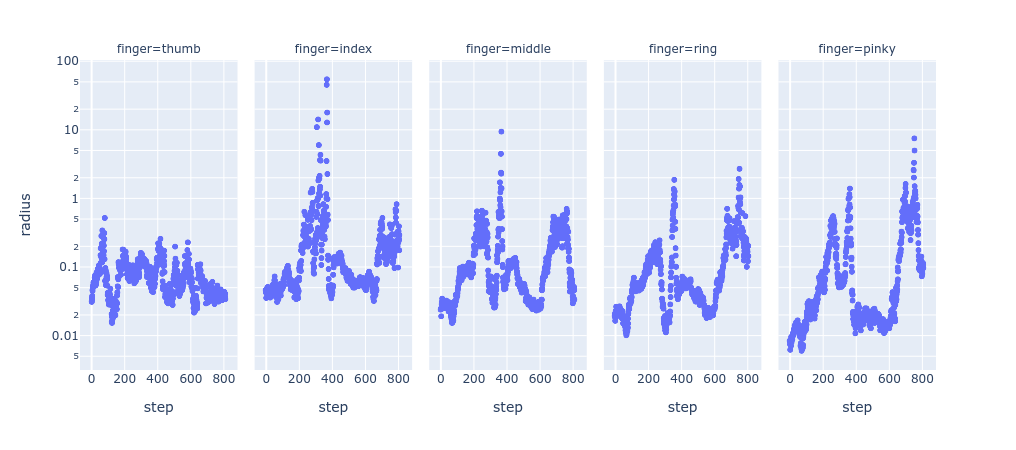

In [11]:
rad_df = df[["step", "radius", "finger"]]
rad_df = rad_df.drop_duplicates().dropna()

# Note: using log-scale for plotting
px.scatter(rad_df, x="step", y="radius", log_y=True, facet_col="finger")

The radii can range from 0 to almost infinity, so we need a way of normalizing them to have a bounded range (e.g. [0, 1]. One way to do this is to use the function:

$$y = \frac{arctan(r - \lambda)}{{\pi}/{2}}$$

where $\lambda$ is a shift parameter (in our case this should be the approximate minimum radius the circle can have).

As a first approximation, we can take one of the smallest values from our dataset for $\lambda$:

In [12]:
shift = rad_df["radius"].quantile(0.05)
print(shift)

0.01514555952464425


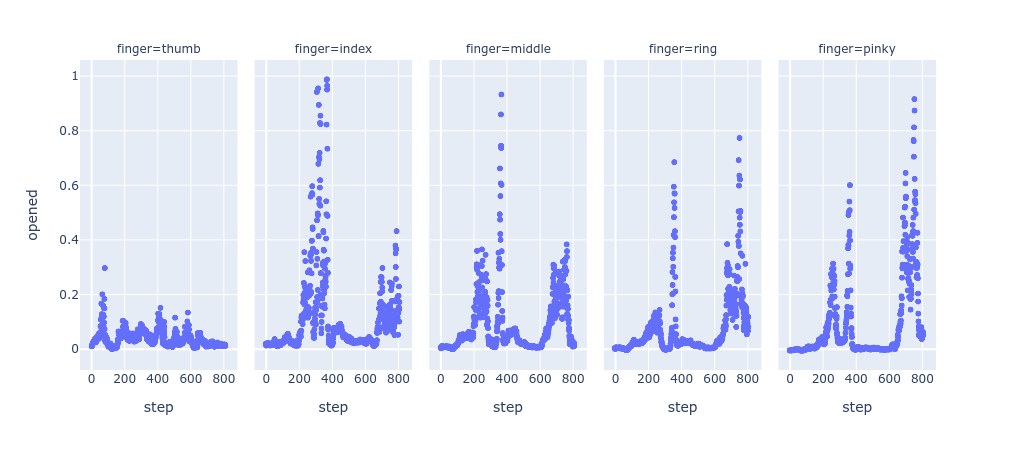

In [13]:
rad_df["opened"] = np.arctan(1 * rad_df["radius"] - shift) / (np.pi / 2) * 1
px.scatter(rad_df, x="step", y="opened", facet_col="finger")

The data is still a bit noisy, we can likely benefit by smoothing the data a bit:

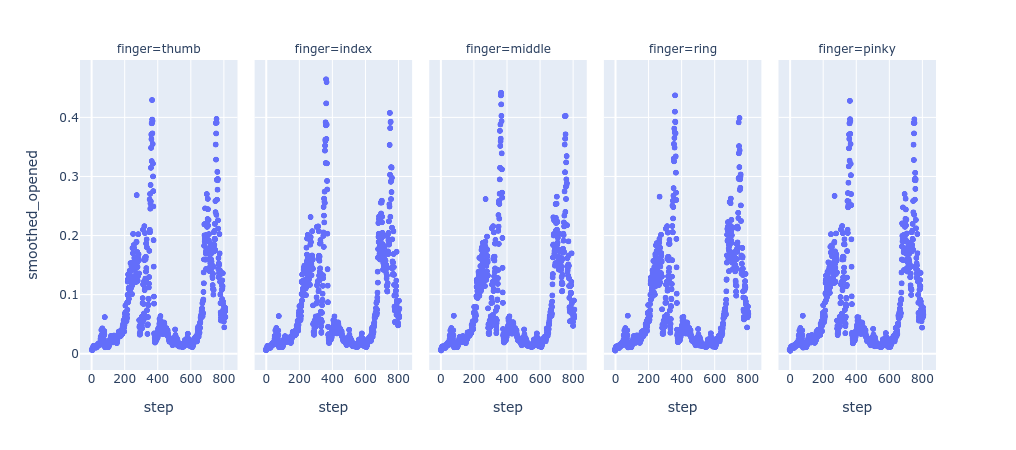

In [14]:
# Smooths using a rolling-window average. The window size here is the number of "steps"
# or frames. If the recording is at 30fps, a window of 30 would be a 1 second window.
smoothed = rad_df.rolling(window=5, on="step").mean()

rad_df["smoothed_opened"] = smoothed["opened"]

px.scatter(rad_df, x="step", y="smoothed_opened", facet_col="finger")